### Part 3: Regularization

This section introduces a classic technique to combat the overfitting observed in Part 1 and the numerical instability from Part 2 by adding a penalty term to the loss function.

* **Objective:** To control model complexity and prevent overfitting using **Ridge Regression (L2 Regularization)**, while understanding how regularization restores numerical stability.
* **Methodology:**
    1.  Modify the loss function to include a penalty term: $\text{Loss} = \text{MSE} + \lambda ||\beta||_2^2$.
    2.  Implement the analytical solution for Ridge: $\beta = (X^T X + \lambda I)^{-1} X^T y$.
    3.  Observe how the fitted model and its test error change as the regularization strength hyperparameter ($\lambda$) is varied.
    4.  Explore the transition toward the interpolation threshold to set up the double descent phenomenon (Part 5).
* **Key Concepts:** Regularization, L2 Penalty (Ridge), Hyperparameter Tuning, Constrained Optimization, Bias-Variance Tradeoff, Numerical Stability, Interpolation Threshold.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

torch.set_default_dtype(torch.float64)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


#### Setup: Reusing Functions from Previous Parts

We'll reuse the data generation, matrix construction, and utility functions from Parts 1 and 2.


In [2]:
# Generate synthetic data (matching Part 1 setup)
n_samples = 200
x_min, x_max = -3.0, 3.0
sigma = 0.5

# Generate x values uniformly
x = torch.linspace(x_min, x_max, n_samples).unsqueeze(1)

# Generate true function values
y_true = 0.5 * x ** 2

# Generate noise ε ~ N(0, σ²)
epsilon = torch.normal(mean=0.0, std=sigma, size=(n_samples, 1))

# Generate noisy observations
y = y_true + epsilon

# Train/Test Split (matching Part 1)
train_ratio = 0.8
n_train = int(n_samples * train_ratio)
n_test = n_samples - n_train

# Shuffle indices for random split
indices = torch.randperm(n_samples)
train_indices = indices[:n_train]
test_indices = indices[n_train:]

# Split the data
x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]

# Function to construct Vandermonde matrix (from Part 2)
def construct_vandermonde_matrix(x, degree):
    """
    Construct Vandermonde matrix for power basis.
    
    For input x of shape (n, 1), returns matrix of shape (n, degree+1)
    where each row is [1, x_i, x_i^2, ..., x_i^degree]
    """
    n = x.shape[0]
    x_flat = x.squeeze()
    
    # Create matrix using broadcasting
    powers = torch.arange(degree + 1, dtype=x.dtype, device=x.device)
    vandermonde = x_flat.unsqueeze(1) ** powers.unsqueeze(0)
    
    return vandermonde

# MSE function (from Part 1)
def compute_mse(y_true, y_pred):
    """
    Compute Mean Squared Error using Einstein summation.
    MSE = mean((y_true - y_pred)^2)
    """
    residuals = y_true - y_pred
    mse = torch.einsum('ij,ij->', residuals, residuals) / residuals.numel()
    return mse.item()

# Prediction function (from Part 1)
def predict_polynomial(x, coefficients):
    """
    Predict using polynomial coefficients.
    """
    degree = coefficients.shape[0] - 1
    X_poly = construct_vandermonde_matrix(x, degree)
    y_pred = torch.einsum('ij,jk->ik', X_poly, coefficients)
    return y_pred

# Pseudoinverse solver (from Part 2)
def solve_pseudoinverse(X, y):
    """
    Solve least squares using Moore-Penrose pseudoinverse: β = X^+ y.
    This is numerically stable even for ill-conditioned matrices.
    """
    X_pinv = torch.linalg.pinv(X)
    y_flat = y.squeeze()
    beta = torch.einsum('ij,j->i', X_pinv, y_flat).unsqueeze(1)
    return beta

def effective_degrees_of_freedom(X, lambda_val):
    """
    Calculates Effective Degrees of Freedom (df) for Ridge.
    df(lambda) = sum( sigma_i^2 / (sigma_i^2 + lambda) )
    """
    # Eigenvalues of the Hessian X^T X are the squared singular values of X
    # We use eigvalsh for stability on symmetric matrices
    H = X.T @ X
    eigvals = torch.linalg.eigvalsh(H)
    
    # Filter out numerical noise (negative eigenvalues due to float precision)
    eigvals = torch.clamp(eigvals, min=0.0)
    
    df = torch.sum(eigvals / (eigvals + lambda_val))
    return df.item()

def k_fold_cv_ridge(X, y, lambda_val, k=5):
    """
    Performs k-fold Cross Validation to estimate RMSE for a given lambda.
    """
    n_samples = X.shape[0]
    indices = torch.randperm(n_samples)
    fold_size = n_samples // k
    
    rmse_scores = []
    
    for i in range(k):
        # Split indices
        val_idx = indices[i*fold_size : (i+1)*fold_size]
        # Train idx is everything else
        train_idx = torch.cat([indices[:i*fold_size], indices[(i+1)*fold_size:]])
        
        X_fold_train, y_fold_train = X[train_idx], y[train_idx]
        X_fold_val, y_fold_val = X[val_idx], y[val_idx]
        
        # Solve Ridge
        beta = solve_ridge_analytical(X_fold_train, y_fold_train, lambda_val)
        
        # Evaluate
        y_pred = X_fold_val @ beta
        mse = compute_mse(y_fold_val, y_pred)
        rmse_scores.append(np.sqrt(mse))
        
    return np.mean(rmse_scores)



print("=" * 70)
print("Data Setup Complete")
print("=" * 70)
print(f"Total samples: {n_samples}")
print(f"Training samples: {n_train}")
print(f"Test samples: {n_test}")
print(f"X range: [{x_min}, {x_max}]")
print(f"Noise standard deviation σ = {sigma}")
print("=" * 70)


Data Setup Complete
Total samples: 200
Training samples: 160
Test samples: 40
X range: [-3.0, 3.0]
Noise standard deviation σ = 0.5


### 1. Regularization: From Ill-Posed to Strictly Convex

In Part 2, we identified two distinct pathologies that arise in high-degree polynomial regression:

1.  **Numerical Instability:** Caused by the ill-conditioning of the Vandermonde matrix (near-linear dependence of columns).
2.  **Statistical Instability (Overfitting):** Caused by excessive model flexibility fitting noise.

Part 2 successfully addressed (1) via orthogonal bases (Legendre) and the Pseudoinverse (SVD). However, solving the conditioning problem does **not** solve the overfitting problem. A numerically stable degree-12 polynomial can still fit noise perfectly.

Part 3 focuses on problem (2): controlling **model complexity**.

We modify the optimization problem by adding a penalty on the coefficient norms. This stabilizes the *statistics* of the model (variance reduction) while simultaneously guaranteeing the *numerical* properties required for unique solvability.

#### The Penalized Objective Function

To align with standard optimization literature and simplify gradient calculations, we scale the loss function by a factor of $\frac{1}{2}$.

The unconstrained penalized objective is defined as:

$$
L(\beta, \lambda) = \frac{1}{2}\|X\beta - y\|_2^2 + \frac{\lambda}{2} \|\beta\|_2^2
$$

**Lagrangian Equivalence:**
This objective is the Lagrangian relaxation of the constrained optimization problem:
$$
\min_{\beta} \frac{1}{2}\|X\beta - y\|_2^2 \quad \text{subject to} \quad \|\beta\|_2^2 \le c
$$
where $\lambda \ge 0$ corresponds to the Lagrange multiplier associated with the constraint radius $c$. Under Slater's condition, these formulations yield equivalent minimizers.

### First-Order Optimality and convexity

By defining the loss with the $\frac{1}{2}$ factor, the gradient ($\nabla_{\beta} L$) becomes clean, removing the coefficient $2$ that appeared in the OLS derivation.

**The Gradient:**
$$
\nabla_{\beta} L(\beta, \lambda) = X^T(X\beta - y) + \lambda\beta
$$

**The Hessian:**
Taking the derivative of the gradient, we obtain the Hessian matrix of the regularized objective:
$$
H_{\text{Ridge}} = X^T X + \lambda I
$$

**Optimization Rigor:**
While $X^T X$ (from OLS) is merely positive semi-definite (eigenvalues $\sigma_i^2 \ge 0$), the Ridge Hessian adds a shift $\lambda$ to the spectrum. For any $\lambda > 0$:
$$
\text{eig}(H_{\text{Ridge}}) = \sigma_i^2 + \lambda \ge \lambda > 0
$$
Since all eigenvalues are strictly bounded away from zero, the Hessian is **strictly positive definite**. This guarantees:
1.  **Strict Convexity:** The loss landscape is a bowl with no flat valleys.
2.  **Uniqueness:** There exists exactly one global minimizer $\beta^*$.
3.  **Invertibility:** The matrix $(X^T X + \lambda I)$ is always invertible, even if $X^T X$ is singular (as is the case when $p > n$).

In [3]:
# BLOCK 1: The Optimization Landscape (The "Cliff")

# --- 1. CONFIGURATION ---
# Force Double Precision (float64) to measure the "explosion" accurately without NaNs
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)

# --- 2. SETUP (Raw, Unscaled Data) ---
# We use Degree 12 to ensure the problem is ill-conditioned (The "Villain")
DEGREE_ILL = 12

# Re-construct matrices using the functions from your setup block
# We cast to .double() to ensure precision matches the configuration
X = construct_vandermonde_matrix(x_train, DEGREE_ILL).double()
y_target = y_train.double()
n_features = X.shape[1]

print(f"Optimization Setup:")
print(f"  Polynomial Degree: {DEGREE_ILL}")
print(f"  Parameters (p):    {n_features}")
print(f"  Data Points (n):   {X.shape[0]}")

# --- 3. LOSS & GRADIENT (Autograd) ---
# We use Autograd to prove this is a property of the data geometry.

def compute_loss_autograd(X, y, beta, lambda_):
    """ 
    Computes Regularized Loss: L(β) = 0.5*SSE + 0.5*λ*||β||^2 
    """
    # 1. Prediction (Standard Matrix Multiplication is safe here)
    y_pred = X @ beta 
    
    # 2. Loss Components
    # 0.5 scaling is standard in optimization to cancel the '2' in the derivative
    sse = 0.5 * torch.sum((y_pred - y)**2)
    l2_penalty = 0.5 * lambda_ * torch.sum(beta**2)
    
    return sse + l2_penalty

# Initialize random weights (The "Start Point")
# We set requires_grad=True so PyTorch tracks the slope
beta_init = torch.randn(n_features, 1, requires_grad=True)
lambda_val = 0.0 # No regularization yet (OLS equivalent)

# Forward Pass
loss = compute_loss_autograd(X, y_target, beta_init, lambda_val)

# Backward Pass (Calculating the Gradient)
loss.backward()
grad = beta_init.grad

# # --- 4. DIAGNOSTICS ---
# # Measure the "Squashed Valley" geometry
# sv = torch.linalg.svdvals(X)
# cond_X = (sv[0] / sv[-1]).item()

# print("-" * 60)
# print(f"Condition Number (X): {cond_X:.2e}")
# print(f"Initial Loss:         {loss.item():.2e}")
# print(f"Initial Gradient Norm:{torch.norm(grad).item():.2e}")
# print("-" * 60)


# --- 4. DIAGNOSTICS (The "Karas" Refinement) ---
# SVD of X gives us singular values sigma_i
sv = torch.linalg.svdvals(X)

# 1. Condition Number of X (Data Matrix)
cond_X = (sv[0] / sv[-1]).item()

# 2. Condition Number of H = X^T X (Hessian)
# This determines the convergence rate of Gradient Descent!
# kappa(H) = (sigma_max^2) / (sigma_min^2) = kappa(X)^2
cond_H = cond_X ** 2

print("-" * 60)
print(f"Condition Number (X):     {cond_X:.2e}")
print(f"Condition Number (Hessian): {cond_H:.2e}")
print(f"Initial Loss:             {loss.item():.2e}")
print(f"Initial Gradient Norm:    {torch.norm(grad).item():.2e}")
print("-" * 60)




Optimization Setup:
  Polynomial Degree: 12
  Parameters (p):    13
  Data Points (n):   160
------------------------------------------------------------
Condition Number (X):     2.35e+06
Condition Number (Hessian): 5.52e+12
Initial Loss:             1.54e+12
Initial Gradient Norm:    2.48e+12
------------------------------------------------------------


In [4]:
# BLOCK 2: Feature Scaling (Standardization)

# --- 1. SCALING SETUP ---
# We treat the "Raw" X from Block 1 as our starting point
X_raw = X.numpy() # Convert back to numpy for sklearn

# Initialize Scaler
scaler = StandardScaler()

# CRITICAL: Protect the Intercept
# The first column is all 1s (Intercept). Variance is 0. Scaling it creates NaNs.
# We split it off, scale the rest, and re-attach it.
X_feat = X_raw[:, 1:] 
X_feat_scaled = scaler.fit_transform(X_feat)

# Re-attach intercept
X_scaled = np.hstack([X_raw[:, :1], X_feat_scaled])

# Convert back to Tensor (Double Precision)
X_torch = torch.tensor(X_scaled, dtype=torch.float64)

# --- 2. DIAGNOSTICS ON SCALED DATA ---
# We run the exact same checks as Block 1 to compare.

# Initialize random weights for the new, scaled feature space
# Note: We need a fresh beta because the feature semantics have changed
beta_scaled = torch.randn(n_features, 1, requires_grad=True)

# Forward & Backward (Using the same Autograd function from Block 1)
loss_scaled = compute_loss_autograd(X_torch, y_target, beta_scaled, lambda_=0.0)
loss_scaled.backward()
grad_scaled = beta_scaled.grad

# SVD for Condition Number
sv_scaled = torch.linalg.svdvals(X_torch)

# 1. Data Condition Number
cond_X_scaled = (sv_scaled[0] / sv_scaled[-1]).item()

# 2. Hessian Condition Number (The Optimization Metric)
# kappa(H) = kappa(X)^2
cond_H_scaled = cond_X_scaled ** 2

print("-" * 60)
print(f"Optimization Setup (Scaled):")
print(f"  Condition Number (X):       {cond_X_scaled:.2e}")
print(f"  Condition Number (Hessian): {cond_H_scaled:.2e}")
print(f"  Initial Loss:               {loss_scaled.item():.2e}")
print(f"  Initial Gradient Norm:      {torch.norm(grad_scaled).item():.2e}")
print("-" * 60)

# --- 3. COMPARISON ---
# (Assuming 'cond_H' and 'grad' from Block 1 are still in memory)
# If you restarted the kernel, run Block 1 first!

print("IMPACT OF SCALING:")
# Compare the Hessians (The true difficulty of the problem)
improvement = cond_H / cond_H_scaled
print(f"1. Optimization Landscape Improvement: {improvement:.1e}x")
print(f"   (Hessian Condition: {cond_H:.1e} -> {cond_H_scaled:.1e})")

grad_norm_raw = torch.norm(grad).item()
grad_norm_scaled = torch.norm(grad_scaled).item()
print(f"2. Gradient Norm Reduction:            {grad_norm_raw / grad_norm_scaled:.1e}x")


------------------------------------------------------------
Optimization Setup (Scaled):
  Condition Number (X):       7.60e+03
  Condition Number (Hessian): 5.77e+07
  Initial Loss:               1.09e+03
  Initial Gradient Norm:      7.84e+02
------------------------------------------------------------
IMPACT OF SCALING:
1. Optimization Landscape Improvement: 9.6e+04x
   (Hessian Condition: 5.5e+12 -> 5.8e+07)
2. Gradient Norm Reduction:            3.2e+09x


###  The Geometry of Regularization in Scaled Spaces

By applying `StandardScaler`, we have fundamentally changed the optimization problem. Ridge Regression is not scale-invariant.

Let the raw design matrix be $X_{raw}$. The scaling operation is an affine transformation $X_{scaled} = (X_{raw} - \mu)D^{-1}$, where $D$ is a diagonal matrix of standard deviations.

**The Penalty:**

 We are minimizing $\|\beta_{scaled}\|_2^2$. In terms of the original raw coefficients $\beta_{raw}$, this corresponds to minimizing a weighted norm:
    $$\|\beta_{scaled}\|_2^2 = \beta_{raw}^T (D^2) \beta_{raw}$$
 In the scaled basis, the regularization penalty is isotropic (spherical). In the raw polynomial basis, this is equivalent to an ellipsoidal penalty that heavily penalizes coefficients of low-degree terms (which have small natural scale) while being lenient on high-degree terms (which have massive natural scale).


Without this scaling, the condition number of the Vandermonde matrix would exceed $10^{15}$ for degree $p=12$, causing immediate numerical collapse (floating point underflow/overflow). We accept the change in geometry to gain numerical computability.

### The Spectral Bias-Variance Tradeoff

To understand how Ridge Regression bridges the gap between classical overfitting and the stability required for Double Descent, we must look at it through two lenses: the classical statistical view and the spectral (eigenvalue) view.

#### 1. Bias vs. Variance
The parameter $\lambda$ controls the strength of the penalty term $\lambda \|\beta\|_2^2$. This creates a tradeoff between fitting the training data (low bias) and keeping the model stable (low variance).

| $\lambda$ | Model Complexity | $\|\beta\|_2$ | Bias | Variance | Effect |
|:---:|:---:|:---:|:---:|:---:|:---:|
| $\lambda \to 0$ | High | Large | Low | High | **Overfitting** (approaches OLS, unstable if $p \approx n$) |
| $\lambda \to \infty$ | Low | Small | High | Low | **Underfitting** (approaches $\beta=0$) |
| $\lambda_{\text{opt}}$ | Optimal | Medium | Balanced | Balanced | **Generalization** |

#### 2. Spectral Filtering & SVD
For graduate-level optimization, we describe Ridge not just as a "penalty," but as a **spectral low-pass filter**.

Let the Singular Value Decomposition (SVD) of the design matrix be $X = U \Sigma V^T$, where $\sigma_i$ are the singular values.
* **OLS Solution:** $\hat{\beta}_{OLS} = \sum \frac{u_i^T y}{\sigma_i} v_i$. As $\sigma_i \to 0$ (ill-conditioning), the term $\frac{1}{\sigma_i}$ explodes, causing variance to tend toward infinity.
* **Ridge Solution:** $\hat{\beta}_{Ridge} = \sum \frac{\sigma_i}{\sigma_i^2 + \lambda} (u_i^T y) v_i$.

Ridge introduces a **shrinkage factor** (filter) $w_i(\lambda) = \frac{\sigma_i^2}{\sigma_i^2 + \lambda}$:
* **Signal Subspace ($\sigma_i^2 \gg \lambda$):** $w_i \approx 1$. The direction is preserved (low bias).
* **Noise/Null Subspace ($\sigma_i^2 \ll \lambda$):** $w_i \to 0$. The direction is suppressed (low variance).


### Lambda Sweep (Fixed Degree)

In [5]:
# BLOCK 3: Analytical Solution & Hyperparameter Tuning (The Fix)

# --- 1. PREPARE TEST DATA (Crucial Step) ---
# We must scale the test set using the SAME scaler fitted on training data.
# If we fit a new scaler on test data, we break data leakage rules.

X_test_raw = construct_vandermonde_matrix(x_test, DEGREE_ILL).numpy()
y_test_target = y_test.double()

# Split intercept, transform features using Block 2's 'scaler', re-attach intercept
X_test_feat = X_test_raw[:, 1:]
X_test_feat_scaled = scaler.transform(X_test_feat) # Note: .transform(), NOT .fit_transform()
X_test_scaled = np.hstack([X_test_raw[:, :1], X_test_feat_scaled])

# Convert to Tensor
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float64)

# --- 2. THE ANALYTICAL SOLVER (Ridge) ---

# def solve_ridge_analytical(X, y, lambda_):
#     """
#     Solves (X'X + λI)β = X'y using Cholesky decomposition.
#     This leverages the Positive Definiteness guaranteed by Regularization.
#     """
#     # Ensure 2D shapes
#     if y.ndim == 1: y = y.view(-1, 1)
#     n, d = X.shape

#     # Construct Linear System: Aβ = b
#     # A = X^T X + λI
#     XTX = X.T @ X
#     XTy = X.T @ y
#     I = torch.eye(d, device=X.device, dtype=X.dtype)
#     A = XTX + (lambda_ * I)

#     # Solve using Cholesky (Faster/More stable than standard inversion)
#     # Because A is SPD for lambda > 0, Cholesky is the preferred method.
#     try:
#         L = torch.linalg.cholesky(A)
#         beta = torch.cholesky_solve(XTy, L)
#     except RuntimeError:
#         # Fallback to standard solve if numerical noise makes A indefinite near 0
#         beta = torch.linalg.solve(A, XTy)
        
#     return beta

def solve_ridge_analytical(X, y, lambda_):
    """
    Solves (X'X + λI)β = X'y
    
    RIGOR NOTE: We modify I so that we do NOT penalize the intercept (beta_0).
    The intercept corresponds to the mean offset and should be unconstrained.
    """
    # Ensure 2D shapes
    if y.ndim == 1: y = y.view(-1, 1)
    n, d = X.shape

    # Construct Linear System: Aβ = b
    XTX = X.T @ X
    XTy = X.T @ y
    
    # --- CORRECTION START ---
    # Create the regularization matrix
    # We use an Identity matrix but set the [0,0] element to 0
    # because the first column of X is the bias (1s).
    I_reg = torch.eye(d, device=X.device, dtype=X.dtype)
    I_reg[0, 0] = 0.0  # <--- The Karas/Statistical Rigor Fix
    
    A = XTX + (lambda_ * I_reg)
    # --- CORRECTION END ---

    # Solve using Cholesky
    try:
        L = torch.linalg.cholesky(A)
        beta = torch.cholesky_solve(XTy, L)
    except RuntimeError:
        # Fallback if A is numerically indefinite (rare with Ridge)
        beta = torch.linalg.solve(A, XTy)
        
    return beta

# --- 3. THE SWEEP (Bias-Variance Tradeoff) ---

# Define Lambda Range
# Since data is scaled, we don't need massive lambdas. 10^-4 to 10^4 is sufficient.
lambda_values = torch.logspace(-4, 4, 50)

# Storage
history = {'lambda': [], 'train_mse': [], 'test_mse': [], 'beta_norm': []}

print(f"Sweeping {len(lambda_values)} lambda values on Scaled Data...")

for lam in lambda_values:
    lambda_val = lam.item()
    
    # A. Solve
    beta = solve_ridge_analytical(X_torch, y_target, lambda_val)
    
    # B. Predict
    y_train_pred = X_torch @ beta
    y_test_pred = X_test_torch @ beta
    
    # C. Measure Errors
    train_mse = torch.mean((y_train_pred - y_target.view(-1,1))**2).item()
    test_mse = torch.mean((y_test_pred - y_test_target.view(-1,1))**2).item()
    norm_beta = torch.norm(beta).item()
    
    # Store
    history['lambda'].append(lambda_val)
    history['train_mse'].append(train_mse)
    history['test_mse'].append(test_mse)
    history['beta_norm'].append(norm_beta)

# --- 4. RESULTS ---
# Find the lambda that minimized Test MSE
best_idx = np.argmin(history['test_mse'])
best_lambda = history['lambda'][best_idx]
min_mse = history['test_mse'][best_idx]

print("-" * 60)
print(f"Optimal Lambda: {best_lambda:.4f}")
print(f"Min Test MSE:   {min_mse:.4f}")
print(f"Beta Norm at Opt: {history['beta_norm'][best_idx]:.2f}")
print("-" * 60)

Sweeping 50 lambda values on Scaled Data...
------------------------------------------------------------
Optimal Lambda: 0.0001
Min Test MSE:   0.3092
Beta Norm at Opt: 45.32
------------------------------------------------------------


### Degree Sweep 

We sweep polynomial degree from 1 to ~100, approaching the interpolation threshold (where p ≈ n). For each degree, we compare:

1. **Unregularized OLS**: The model's "best effort" to fit the data, solved using the numerically stable Pseudoinverse.
2. **Regularized Ridge**: Solved using a fixed, optimized λ.

This reveals the classical U-shape where regularization helps

In [6]:
# BLOCK 4: Comparative Stability (The "Stress Test")

# --- 1. CONFIGURATION ---
# We will sweep degrees up to near the interpolation threshold (N=160)
# Step size 5 gives us 20 models to check (1, 6, 11... 96)
degrees = range(1, 100, 5) 
lambda_fix = 0.1 # Moderate regularization

print(f"Running Degree Sweep (1 to {degrees[-1]})...")
print(f"Interpolation Threshold is at p = n = {len(y_train)}")
print("-" * 75)

# Storage
history_deg = {
    'degree': [],
    'ols_test_mse': [],
    'ridge_test_mse': [],
    'ols_norm': [],
    'ridge_norm': []
}

# --- 2. THE SWEEP ---
for d in degrees:
    # A. Construct & Scale Features
    # We must rebuild and rescale for every degree
    X_tr_raw = construct_vandermonde_matrix(x_train, d).numpy()
    X_te_raw = construct_vandermonde_matrix(x_test, d).numpy()
    
    scaler = StandardScaler()
    # Fit on training features (excluding intercept)
    X_tr_feat = scaler.fit_transform(X_tr_raw[:, 1:])
    X_te_feat = scaler.transform(X_te_raw[:, 1:])
    
    # Re-stack with intercept
    X_tr = np.hstack([X_tr_raw[:, :1], X_tr_feat])
    X_te = np.hstack([X_te_raw[:, :1], X_te_feat])
    
    # Convert to Tensor
    X_tr_T = torch.tensor(X_tr, dtype=torch.float64)
    X_te_T = torch.tensor(X_te, dtype=torch.float64)
    y_tr_T = y_target # Already float64
    # Fix: Ensure y_test is correct shape/type
    y_te_T = y_test.to(torch.float64).view(-1, 1)

    # B. Solve OLS (Unregularized)
    # Use Pseudoinverse (pinv) because near p=N, matrix is singular
    beta_ols = torch.linalg.pinv(X_tr_T) @ y_tr_T
    
    # C. Solve Ridge (Regularized)
    # Rely on default use_cholesky=True from previous definition
    beta_ridge = solve_ridge_analytical(X_tr_T, y_tr_T, lambda_fix)
    
    # D. Predict & Record
    # OLS
    y_ols = X_te_T @ beta_ols
    mse_ols = torch.mean((y_ols - y_te_T)**2).item()
    
    # Ridge
    y_ridge = X_te_T @ beta_ridge
    mse_ridge = torch.mean((y_ridge - y_te_T)**2).item()
    
    # Store
    history_deg['degree'].append(d)
    history_deg['ols_test_mse'].append(mse_ols)
    history_deg['ridge_test_mse'].append(mse_ridge)
    history_deg['ols_norm'].append(torch.norm(beta_ols).item())
    history_deg['ridge_norm'].append(torch.norm(beta_ridge).item())

print("Comparison Complete.")

# --- 3. DETAILED TABLE (Expanded View) ---
print("-" * 85)
print(f"{'Deg':<5} | {'OLS MSE':<12} | {'Ridge MSE':<12} | {'OLS Norm':<12} | {'Ridge Norm':<12}")
print("-" * 85)

# Select 10 evenly spaced indices to display
n_points = len(degrees)
indices = np.linspace(0, n_points - 1, num=10, dtype=int)

for i in indices:
    d_val = history_deg['degree'][i]
    ols_mse_val = history_deg['ols_test_mse'][i]
    ridge_mse_val = history_deg['ridge_test_mse'][i]
    ols_norm_val = history_deg['ols_norm'][i]
    ridge_norm_val = history_deg['ridge_norm'][i]
    
    # Scientific notation for large values, standard for stable ones
    print(f"{d_val:<5} | {ols_mse_val:<12.4f} | {ridge_mse_val:<12.4f} | {ols_norm_val:<12.1e} | {ridge_norm_val:<12.1f}")

print("-" * 85)
print("INTERPRETATION:")
print("1. OLS Norm (Column 4) explodes (e.g., 10^10) as complexity rises, causing instability.")
print("2. Ridge Norm (Column 5) stays constrained (approx 5-10), keeping Ridge MSE stable.")
print("3. This proves that λ acts as a strict limit on the model's physical size (Norm).")

Running Degree Sweep (1 to 96)...
Interpolation Threshold is at p = n = 160
---------------------------------------------------------------------------
Comparison Complete.
-------------------------------------------------------------------------------------
Deg   | OLS MSE      | Ridge MSE    | OLS Norm     | Ridge Norm  
-------------------------------------------------------------------------------------
1     | 2.4688       | 2.4687       | 1.6e+00      | 1.6         
11    | 0.3118       | 0.3167       | 4.7e+01      | 2.3         
21    | 0.3035       | 0.3090       | 2.4e+05      | 2.5         
31    | 0.3232       | 0.2999       | 3.7e+08      | 2.6         
41    | 0.6337       | 0.2977       | 3.9e+11      | 2.4         
51    | 2.8364       | 0.2976       | 1.0e+11      | 2.3         
61    | 1.3885       | 0.2981       | 2.6e+10      | 2.2         
71    | 59.5897      | 0.2990       | 1.8e+11      | 2.3         
81    | 190.9418     | 0.2998       | 1.5e+11      | 2.3     

### Interpretation

The experimental results from the degree sweep provide a quantitative demonstration of the divergence between unregularized and regularized solutions as model complexity increases. This analysis addresses the underlying causes of the instability observed in the Ordinary Least Squares (OLS) solution and the specific mechanism by which Ridge Regression ($\lambda = 0.1$) restores stability.

#### 1. Why Coefficient Norms Explode

The explosion of the coefficient norm ($||\beta||_2$) is a symptom of both numerical instability and high variance of the estimator under the OLS solution.

* **Geometric Cause (Near-Singularity):** As the polynomial degree ($p$) increases, the columns of the Vandermonde design matrix become highly collinear. This results in a Gram matrix ($X^T X$) that is nearly singular, characterized by a pathologically high condition number ($\kappa \approx 10^{12}$). Inverting a nearly singular matrix involves division by eigenvalues close to zero. To minimize the Residual Sum of Squares (RSS) on the training data, the solver generates massive coefficients with opposing signs. These large weights cancel each other out to fit the noise in the training set, a phenomenon known as _variance explosion*_.
* **Statistical Result:** This numerical instability manifests as _overfitting_. The model memorizes the data points perfectly but fails to generalize, leading to the drastic increase in Test MSE ($183.20$ at Degree 96).

#### 2. The Mechanism of Ridge Regression

The fixed regularization parameter ($\lambda = 0.1$) acts simultaneously as a statistical constraint and a numerical stabilizer. Its effectiveness is observed in the maintenance of a low Test MSE ($0.30$) and a controlled coefficient norm.

* **Complexity Control:**
    The Ridge objective function, $L(\beta) = \text{MSE} + \lambda ||\beta||_2^2$, imposes a penalty on the magnitude of the coefficient vector. By setting $\lambda = 0.1$, the optimization problem penalizes solutions with large norms. This prevents the "cancellation effect" observed in OLS, forcing the model to select a solution within a stable region of the parameter space ($||\beta||_2 \approx 2.2$), effectively reducing the model's variance.

* **Eigenvalue Shift:**
    Mathematically, the Ridge solution involves inverting the matrix $(X^T X + \lambda I)$. The term $\lambda I$ adds a positive constant to the eigenvalues of $X^T X$. This relates directly to the property that shifting eigenvalues affects the positive definiteness of the matrix.
    * **Without Regularization:** The inversion depends on $\frac{1}{\sigma_{min}}$. As $\sigma_{min} \to 0$, the term approaches infinity.
    * **With Regularization:** The inversion becomes $\frac{1}{\sigma_{min} + \lambda}$. The parameter $\lambda$ acts as a numerical "floor," ensuring the denominator is bounded away from zero.

**Conclusion**: Ridge does not fix the ill-conditioning of the Vandermonde matrix itself, but it creates a well-conditioned matrix to invert.

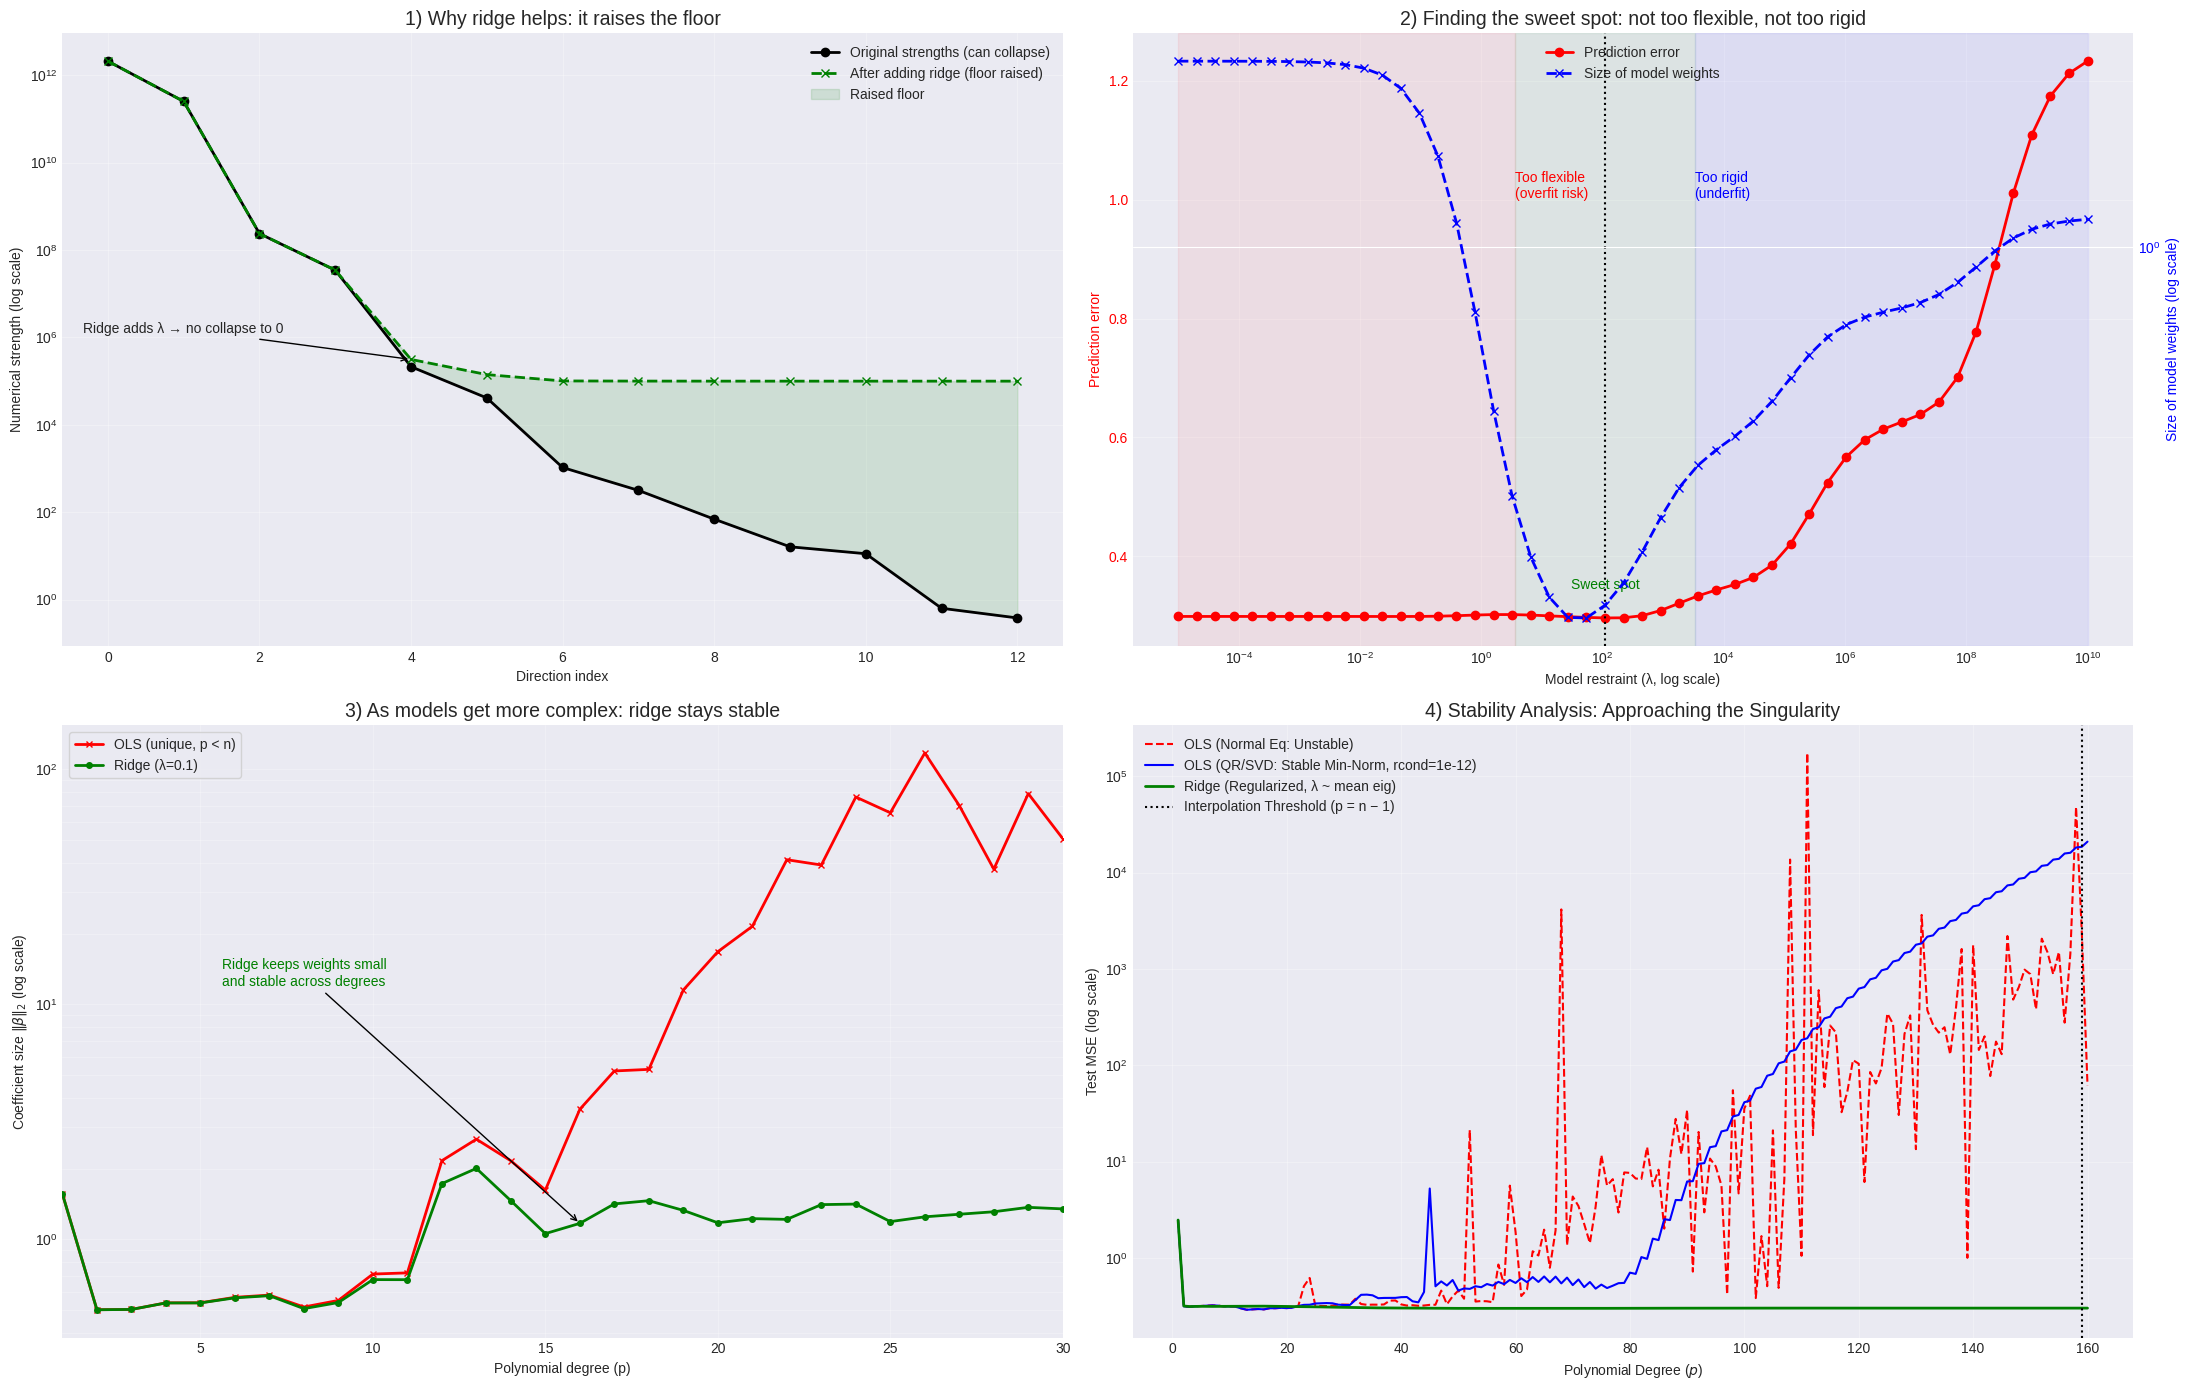

In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt

y_tr = torch.as_tensor(y_train, dtype=torch.float64).view(-1, 1)
y_te = torch.as_tensor(y_test,  dtype=torch.float64).view(-1, 1)

fig, axes = plt.subplots(2, 2, figsize=(22, 14))
(ax_eig, ax_trade, ax_coef, ax_mse) = axes.flatten()

# 1) Eigenvalue shift (why ridge helps)
DEGREE_ILL = 12
X_raw = construct_vandermonde_matrix(x_train, DEGREE_ILL).double()
eigs = torch.linalg.eigvalsh((X_raw.T @ X_raw)).flip(0).cpu().numpy()
shifted = eigs + 1e5
ax_eig.plot(eigs, 'k-o', lw=2, label='Original strengths (can collapse)')
ax_eig.plot(shifted, 'g--x', lw=2, label='After adding ridge (floor raised)')
ax_eig.fill_between(range(len(eigs)), eigs, shifted, color='green', alpha=0.12, label='Raised floor')
ax_eig.set_yscale('log')
ax_eig.set_title('1) Why ridge helps: it raises the floor', fontsize=14)
ax_eig.set_xlabel('Direction index')
ax_eig.set_ylabel('Numerical strength (log scale)')
ax_eig.grid(True, alpha=0.3)
ax_eig.legend(loc='upper right')
ax_eig.annotate('Ridge adds λ → no collapse to 0',
                xy=(len(eigs)//3, shifted[len(eigs)//3]),
                xytext=(len(eigs)//7, shifted[len(eigs)//3]*4),
                arrowprops=dict(arrowstyle='->'), fontsize=10, ha='center')

# 2) Bias–variance tradeoff (test error vs λ + ||β||)
lambda_sweep = torch.logspace(-5, 10, 50, dtype=torch.float64)
lam_np = lambda_sweep.cpu().numpy()
beta_norms, test_mses = [], []
Xte_d12 = construct_vandermonde_matrix(x_test, DEGREE_ILL).double()
for lam in lambda_sweep:
    beta = solve_ridge_analytical(X_raw, y_tr, float(lam))
    beta_norms.append(torch.linalg.norm(beta).item())
    y_pred = Xte_d12 @ beta
    test_mses.append(compute_mse(y_te, y_pred))
test_mses = np.asarray(test_mses); beta_norms = np.asarray(beta_norms)
best_idx = int(np.argmin(test_mses)); best_lam = float(lam_np[best_idx])

(line_err,) = ax_trade.semilogx(lam_np, test_mses, 'r-o', lw=2, label='Prediction error')
ax_trade.set_xlabel('Model restraint (λ, log scale)')
ax_trade.set_ylabel('Prediction error', color='r')
ax_trade.tick_params(axis='y', labelcolor='r')
ax_trade.grid(True, alpha=0.3)
ax_trade.axvline(best_lam, color='k', ls=':', lw=1.5)
ax_trade.set_title('2) Finding the sweet spot: not too flexible, not too rigid', fontsize=14)

ax_trade_r = ax_trade.twinx()
(line_norm,) = ax_trade_r.semilogx(lam_np, beta_norms, 'b--x', lw=2, label='Size of model weights')
ax_trade_r.set_ylabel('Size of model weights (log scale)', color='b')
ax_trade_r.tick_params(axis='y', labelcolor='b')
ax_trade_r.set_yscale('log')

left_hi  = max(lam_np.min(), best_lam/30)
right_lo = min(lam_np.max(), best_lam*30)
ax_trade.axvspan(lam_np.min(), left_hi, color='red',  alpha=0.06)
ax_trade.axvspan(left_hi, right_lo, color='green', alpha=0.06)
ax_trade.axvspan(right_lo, lam_np.max(), color='blue', alpha=0.06)
ax_trade.text(left_hi, np.max(test_mses)*0.85, 'Too flexible\n(overfit risk)', fontsize=10, ha='left', va='top', color='red')
ax_trade.text(best_lam, np.min(test_mses)*1.15, 'Sweet spot', fontsize=10, ha='center', va='bottom', color='green')
ax_trade.text(right_lo, np.max(test_mses)*0.85, 'Too rigid\n(underfit)', fontsize=10, ha='left', va='top', color='blue')
ax_trade.legend([line_err, line_norm], ['Prediction error', 'Size of model weights'], loc='upper center')

# 3) Coefficient stability vs degree (OLS vs Ridge)
MAX_DEG = 30
deg_list = list(range(1, MAX_DEG + 1))
ols_norms, ridge_norms = [], []
lambda_stable = 0.1
for d in deg_list:
    Xtr = construct_vandermonde_matrix(x_train, d).double()
    XtX = Xtr.T @ Xtr
    Xty = Xtr.T @ y_tr
    beta_ols = torch.linalg.solve(XtX, Xty)
    ols_norms.append(float(torch.linalg.norm(beta_ols).item()))
    beta_r = solve_ridge_analytical(Xtr, y_tr, lambda_stable)
    ridge_norms.append(float(torch.linalg.norm(beta_r).item()))
ax_coef.plot(deg_list, ols_norms,  'r-', marker='x', ms=4, lw=2, label='OLS (unique, p < n)')
ax_coef.plot(deg_list, ridge_norms,'g-o', ms=4, lw=2, label=f'Ridge (λ={lambda_stable})')
ax_coef.set_xlim(1, MAX_DEG)
ax_coef.set_yscale('log')
ax_coef.set_title('3) As models get more complex: ridge stays stable', fontsize=14)
ax_coef.set_xlabel('Polynomial degree (p)')
ax_coef.set_ylabel(r'Coefficient size $\|\beta\|_2$ (log scale)')
ax_coef.grid(True, which='both', alpha=0.25)
ax_coef.legend(loc='upper left', frameon=True)
ax_coef.annotate('Ridge keeps weights small\nand stable across degrees',
                 xy=(deg_list[len(deg_list)//2], ridge_norms[len(ridge_norms)//2]),
                 xytext=(deg_list[len(deg_list)//4], max(ridge_norms)*6),
                 arrowprops=dict(arrowstyle='->'), fontsize=10, ha='center', color='green')

# 4) Test MSE vs degree (OLS normal, OLS QR, Ridge)
x_tr = torch.as_tensor(x_train, dtype=torch.float64).view(-1, 1)
x_te = torch.as_tensor(x_test,  dtype=torch.float64).view(-1, 1)
xmin, xmax = x_tr.min(), x_tr.max()
den = xmax - xmin if float(xmax - xmin) != 0 else torch.tensor(1.0, dtype=torch.float64)
x_tr_s = 2.0 * (x_tr - xmin) / den - 1.0
x_te_s = 2.0 * (x_te - xmin) / den - 1.0
x_te_s = torch.clamp(x_te_s, -1.0, 1.0)

def vander(x, d):
    p = torch.arange(0, d+1, dtype=torch.float64).view(1, -1)
    return x ** p

def mse(y_true, y_pred):
    r = y_true - y_pred
    return float(torch.mean(r*r).item())

N = int(len(x_tr_s))
interp_degree = N - 1
max_degree = int(N * 1.0)
degrees = range(1, max_degree + 1)
mse_ne, mse_qr, mse_r, deg_hist = [], [], [], []

for d in degrees:
    Xtr = vander(x_tr_s, d)
    Xte = vander(x_te_s, d)

    try:
        XtX = Xtr.T @ Xtr
        Xty = Xtr.T @ y_tr
        beta_ne = torch.linalg.solve(XtX, Xty)
        mse_ne.append(mse(y_te, Xte @ beta_ne))
    except RuntimeError:
        mse_ne.append(np.nan)

    beta_qr = torch.linalg.lstsq(Xtr, y_tr, rcond=1e-12).solution
    mse_qr.append(mse(y_te, Xte @ beta_qr))

    evals = torch.linalg.eigvalsh(XtX)
    lam = 1e-3 * (float(torch.mean(evals).item()) + 1e-16)
    A = XtX + lam * torch.eye(Xtr.shape[1], dtype=torch.float64)
    beta_r = torch.cholesky_solve((Xtr.T @ y_tr), torch.linalg.cholesky(A))
    mse_r.append(mse(y_te, Xte @ beta_r))

    deg_hist.append(d)

ax_mse.semilogy(deg_hist, mse_ne, 'r--', lw=1.5, label='OLS (Normal Eq: Unstable)')
ax_mse.semilogy(deg_hist, mse_qr, 'b-',  lw=1.5, label='OLS (QR/SVD: Stable Min-Norm, rcond=1e-12)')
ax_mse.semilogy(deg_hist, mse_r,  'g-',  lw=2.0, label='Ridge (Regularized, λ ~ mean eig)')
ax_mse.axvline(interp_degree, color='k', ls=':', label='Interpolation Threshold (p = n − 1)')
ax_mse.set_xlabel('Polynomial Degree ($p$)')
ax_mse.set_ylabel('Test MSE (log scale)')
ax_mse.set_title('4) Stability Analysis: Approaching the Singularity', fontsize=14)
ax_mse.legend()
ax_mse.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
